In [40]:
# Machine learning and NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
import scipy as sp
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import csv
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import wordcloud
import re

In [30]:
df = pd.read_csv('../enron_emails_cleaned.csv')

In [28]:
df.sample(5)

,Date,From,To,Subject,X-From,X-To,X-Folder,Folder,X-Origin,X-Filename,Cotent,Employee,Year,Month
60065,2000-11-14 16:58:00+00:00,mike.mcconnell@enron.com,cathy.phillips@enron.com,Holiday Schedule 2001,Mike McConnell,Cathy Phillips,\Mark_McConnell_June2001\Notes Folders\Sent,sent,MCCONNELL-M,mmcconn.nsf,"CP, please add to my calendar. I'll take home...",mcconnell-m,2000,11
461677,2000-07-30 00:03:00+00:00,james.steffes@enron.com,"steve.kean@enron.com, richard.shapiro@enron.co...",Follow-up on Larcamp Visit: Comparing Gas /Ele...,James D Steffes,steve kean richard shapiro joe hartsoe,\Steven_Kean_Dec2000_1\Notes Folders\Archiving...,untitled,KEAN-S,skean.nsf,FYI. I'll keep all of you posted as we comple...,kean-s,2000,7
190302,2001-11-26 11:52:59+00:00,zagatsurvey@news.zagat.com,legal <.taylor@enron.com>,Free Shipping on Holiday Gifts,zagatsurvey,Taylor Mark E,"\MTAYLO1 (Non-Privileged)\Taylor, Mark E (Lega...",deleted items,Taylor-M,MTAYLO1 (Non-Privileged).pst,\n [IMAGE] [IMAGE] [IMAGE] [IMAGE] [IMA...,taylor-m,2001,11
306632,2001-04-17 18:49:00+00:00,cheryl.johnson@enron.com,"laurel.adams@enron.com, lane.alexander@enron.c...",Name Overlay 0417,Cheryl Johnson,Laurel Adams Lane Alexander Amelia Alland Laur...,\Tanya_Jones_June2001\Notes Folders\All documents,all documents,JONES-T,tjones.nsf,Attached is a Conversion/Name Change for GATX ...,jones-t,2001,4
42803,2001-05-02 09:03:00+00:00,vince.kaminski@enron.com,phillip.randle@enron.com,RE: Installation of new programs,Vince J Kaminski,Phillip Randle,\Vincent_Kaminski_Jun2001_3\Notes Folders\Sent,sent,Kaminski-V,vkamins.nsf,"Philip,\n\nThanks. You are the best.\n\nVince\...",kaminski-v,2001,5


In [31]:
df.isnull().sum()

Date              0
From              0
To                0
Subject       18822
X-From         1300
X-To           7978
X-Folder          0
Folder            0
X-Origin          0
X-Filename     4001
Cotent            0
Employee          0
Year              0
Month             0
dtype: int64

In [32]:
df.dropna(inplace=True)

In [33]:
stopwords = nltk.corpus.stopwords.words('english')
newstopwords = ['Re', 'FW', 'Fwd', 'EOL', 'E', 'mail', 'PLEASE', 'Ahead']
for i in newstopwords:
    stopwords.append(i)

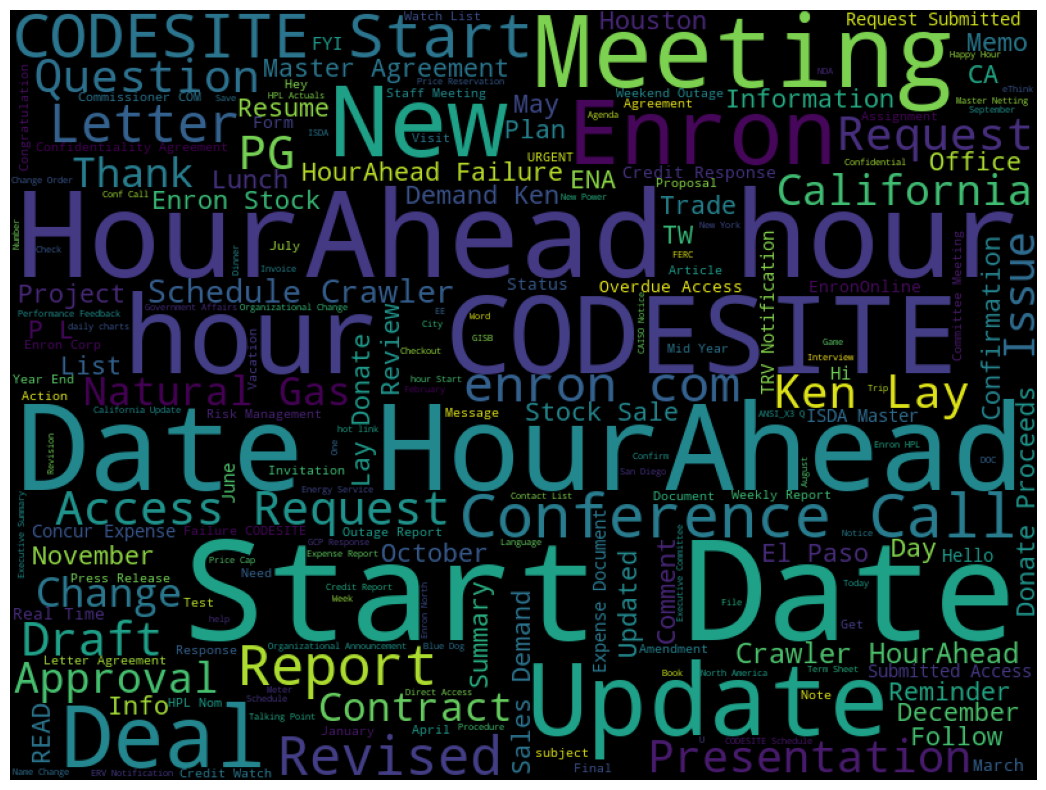

In [34]:
subjects = ' '.join(df['Subject'].values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 200, stopwords = stopwords).generate(subjects)
ax.imshow(wc)
plt.axis('off')
plt.show()

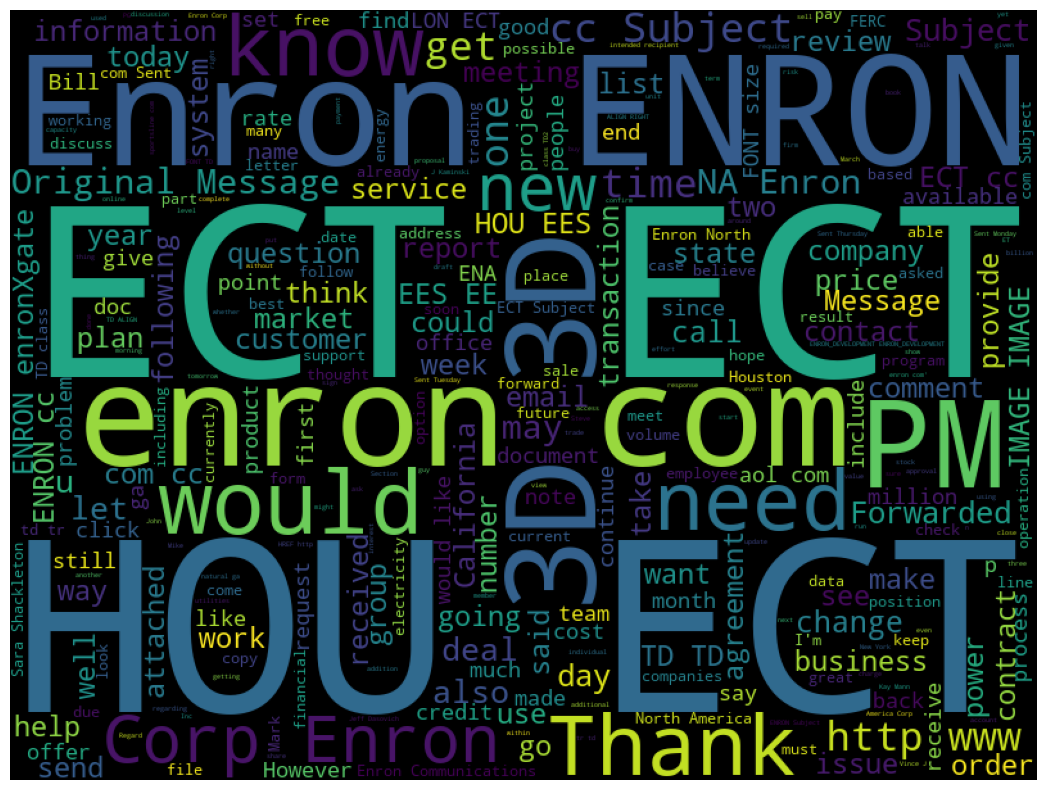

In [37]:
content = ' '.join(df['Cotent'].sample(5000).values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 300, stopwords = stopwords).generate(content)
ax.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
nltk.download('wordnet')

In [ ]:
nltk.download('punkt')

In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [41]:
# function for cleaning the body text
def cleaningbody(col):
    msgcol = []
    for msg in col.values:
        msg = re.sub(r'[<>\n+\t+\s+\*]', ' ', msg)
        msg = re.sub(r'[0-9]+[a-zA-Z]+\d+[?!].DOC', ' ', msg)
        msg = re.sub(r'[?\s+\-+\s+?_=~]', ' ', msg)
        msg = re.sub(r' +', ' ', msg)
        msg = msg.lower().strip(' ')
        msgcol.append(msg)
    return msgcol
df['Cotent'] = cleaningbody(df['Cotent'])

In [ ]:
# preparing the lemmatization function
lemmatizer = WordNetLemmatizer()

In [ ]:
# Tokenizing and lemmatizing the text to prepare for classification and sentiment analysis
text = []
for msg in df['Cotent'].values:
    msg_tokens = word_tokenize(msg)
    msg_tokens = [token.lower() for token in msg_tokens if token.isalpha()]
    msg_tokens = [word for word in msg_tokens if not word in stopwords]
    msg_tokens = [lemmatizer.lemmatize(word) for word in msg_tokens]
    
    text.append(msg_tokens)

In [ ]:
text = [' '.join(message) for message in text]

In [ ]:
# vectorizing the data using Tfidfvectorizer
vectorizer = TfidfVectorizer(min_df = 5, max_features = 5000, stop_words = stopwords, norm = 'l1')
data = vectorizer.fit_transform(text)

In [ ]:
# Normalizing the data
data_norm = normalize(data)

In [ ]:
print(data_norm.shape)

In [ ]:
# Decomposition of the data and decreasing alot of features
svd = TruncatedSVD(n_components = 2, n_iter = 10, random_state = 42)
datasvd = svd.fit_transform(data_norm)

In [ ]:
datasvd.shape

In [ ]:
# Use the Elbow method to define the optimal number of clusters for kmeans clustering
max_iter = 1000
sumsquares = []
number_clusters = range(1,11)
for i in number_clusters:
    kmeans = KMeans(n_clusters = i, max_iter = max_iter, n_init = 'auto')
    kmeans.fit(datasvd)
    sumsquares.append(kmeans.inertia_)
plt.figure(figsize = (8,6))
plt.plot(number_clusters, sumsquares)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Sum of Squared Distances', fontsize = 14)
plt.title('Elbow Method', fontsize = 16)
plt.show()

In [ ]:
n_clusters = 6
clf = KMeans(n_clusters = n_clusters,init = 'random', max_iter = max_iter, tol = 0.0001, algorithm = 'lloyd', n_init = 'auto', random_state = 42)
fittedkmeans = clf.fit_predict(datasvd)
centroids = clf.cluster_centers_

In [ ]:
# A diagram showing the clusters
plt.figure(figsize = (8,6))
plt.scatter(datasvd[:,0], datasvd[:,1], c = fittedkmeans, s = 50, cmap = 'viridis', alpha = 0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], s = 150, c = 'black', alpha = 0.8)
plt.annotate('Cluster 0', xy = (centroids[0][0], centroids[0][1]), xytext = (centroids[0][0] + 0.02, centroids[0][1] + 0.03), color = 'white', fontsize = 12)
plt.annotate('Cluster 1', xy = (centroids[1][0], centroids[1][1]), xytext = (centroids[1][0] + 0.02, centroids[1][1] + 0.02), color = 'white', fontsize = 12)
plt.annotate('Cluster 2', xy = (centroids[2][0], centroids[2][1]), xytext = (centroids[2][0] - 0.05, centroids[2][1] - 0.06), color = 'white', fontsize = 12)
plt.annotate('Cluster 3', xy = (centroids[3][0], centroids[3][1]), xytext = (centroids[3][0] - 0.01, centroids[3][1] - 0.07), color = 'white', fontsize = 12)
plt.annotate('Cluster 4', xy = (centroids[4][0], centroids[4][1]), xytext = (centroids[4][0] - 0.03, centroids[4][1] + 0.04), color = 'white', fontsize = 12)
plt.annotate('Cluster 5', xy = (centroids[5][0], centroids[5][1]), xytext = (centroids[5][0] - 0.03, centroids[5][1] + 0.03), color = 'white', fontsize = 12)

plt.show()

In [ ]:
# extract top words in every cluster using the inverse_transform method
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1] #(10,5000)
terms = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
        
    print()